In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
%matplotlib inline

In [2]:
# define conversion factors
Chl_N=1.8

In [3]:
data=pickle.load(open( 'matched_201905.pkl', 'rb' ) )

In [4]:
data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]

Text(0, 0.5, 'model')

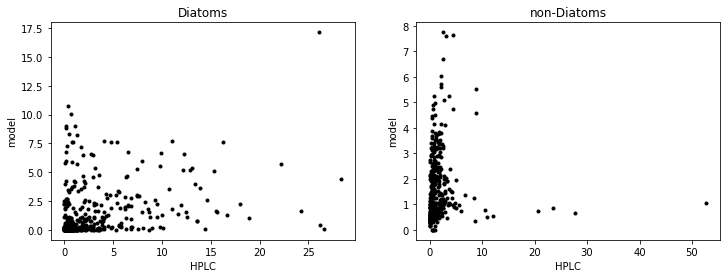

In [5]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(data['Diatoms-1']+data['Diatoms-2'],1.8*data['mod_diatoms'],'k.')
ax[0].set_title('Diatoms')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')

ax[1].plot(data['other'],1.8*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[1].set_title('non-Diatoms')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')

(0, 8)

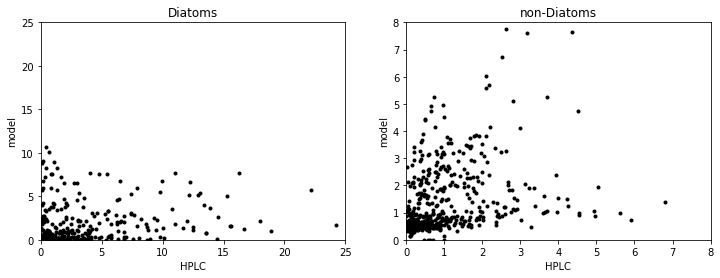

In [6]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(data['Diatoms-1']+data['Diatoms-2'],1.8*data['mod_diatoms'],'k.')
ax[0].set_title('Diatoms')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].set_xlim((0,25))
ax[0].set_ylim((0,25))
ax[1].plot(data['other'],1.8*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[1].set_title('non-Diatoms')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].set_xlim((0,8))
ax[1].set_ylim((0,8))

In [7]:
def logt(x):
    return np.log(x+.001)

Text(0, 0.5, 'model')

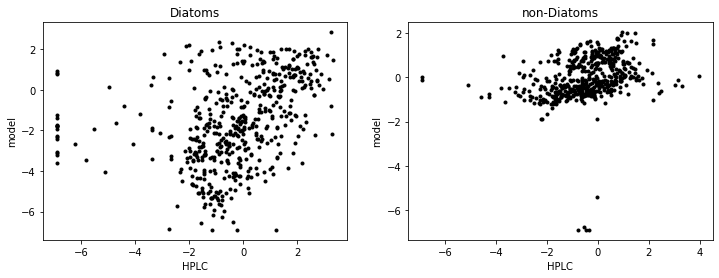

In [8]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(logt(data['Diatoms-1']+data['Diatoms-2']),logt(1.8*data['mod_diatoms']),'k.')
ax[0].set_title('Diatoms')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')

ax[1].plot(logt(data['other']),logt(1.8*(data['mod_flagellates']+data['mod_ciliates'])),'k.')
ax[1].set_title('non-Diatoms')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')

(-4, 3)

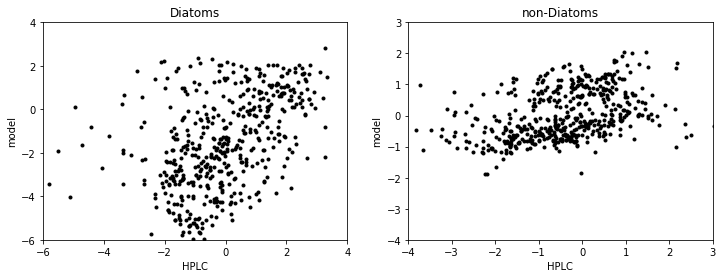

In [9]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(logt(data['Diatoms-1']+data['Diatoms-2']),logt(1.8*data['mod_diatoms']),'k.')
ax[0].set_title('Diatoms')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].set_xlim((-6,4))
ax[0].set_ylim((-6,4))
ax[1].plot(logt(data['other']),logt(1.8*(data['mod_flagellates']+data['mod_ciliates'])),'k.')
ax[1].set_title('non-Diatoms')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].set_xlim((-4,3))
ax[1].set_ylim((-4,3))

Text(0, 0.5, 'model')

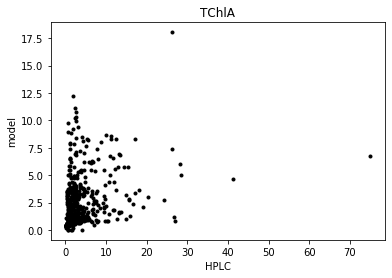

In [10]:
plt.plot(data['TchlA (ug/L)'],1.8*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms']),'k.')
plt.title('TChlA')
plt.xlabel('HPLC')
plt.ylabel('model')

Text(0, 0.5, 'model')

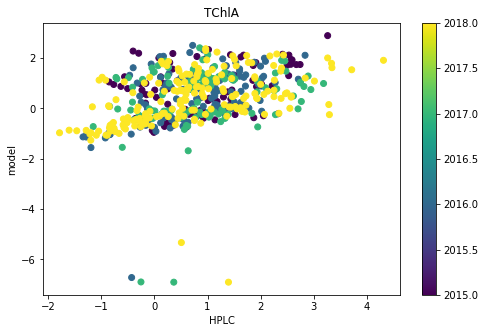

In [11]:
fig,ax=plt.subplots(1,1,figsize=(8,5))
m=ax.scatter(logt(data['TchlA (ug/L)']),logt(1.8*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),
            c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
plt.title('TChlA')
plt.xlabel('HPLC')
plt.ylabel('model')

In [12]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

In [13]:
data['yd']=yd(data['dtUTC'])

In [14]:
data['Year']=[ii.year for ii in data['dtUTC']]

In [15]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

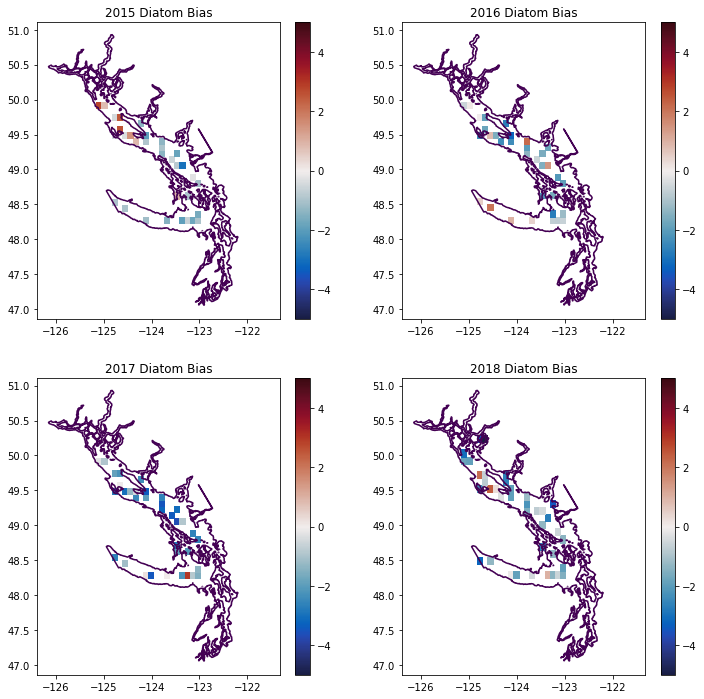

In [16]:
fig,ax=plt.subplots(2,2,figsize=(12,12))
ax=ax.flatten()
for yr in range(2015,2019):
    dyr=data.loc[(data['Year']==yr)&(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&~np.isnan(data['other'])&~np.isnan(data['mod_diatoms'])]
    ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
    ax[yr-2015].set_title(str(yr)+' Diatom Bias')
    s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
                logt(1.8*dyr['mod_diatoms'])-logt(dyr['Diatoms-1']+dyr['Diatoms-2']), 
                statistic='mean', bins=20)
    m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-5,vmax=5,shading='flat')
    plt.colorbar(m,ax=ax[yr-2015])

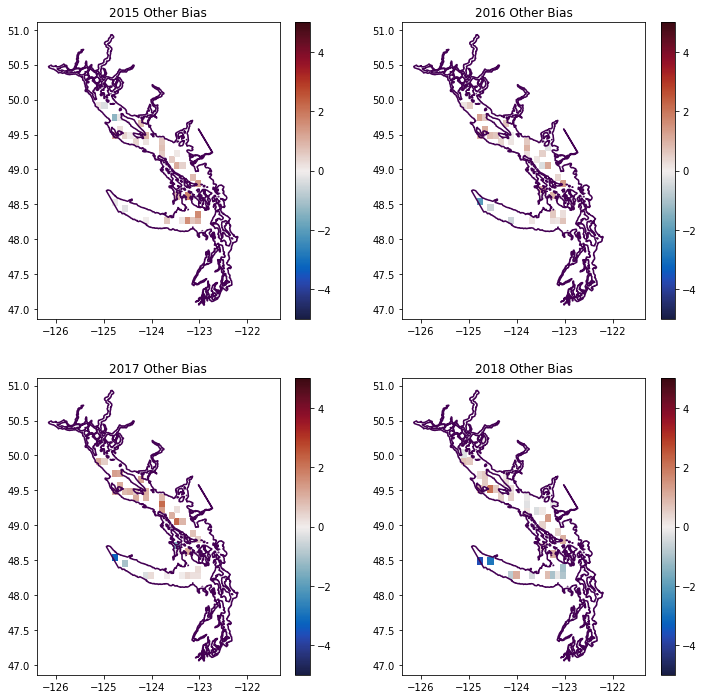

In [17]:
fig,ax=plt.subplots(2,2,figsize=(12,12))
ax=ax.flatten()
for yr in range(2015,2019):
    dyr=data.loc[(data['Year']==yr)&(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&~np.isnan(data['other'])&~np.isnan(data['mod_diatoms'])]
    ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
    ax[yr-2015].set_title(str(yr)+' Other Bias')
    s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
                logt(1.8*(dyr['mod_flagellates']+dyr['mod_ciliates']))-logt(dyr['other']), 
                statistic='mean', bins=20)
    m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-5,vmax=5,shading='flat')
    plt.colorbar(m,ax=ax[yr-2015])

Text(0, 0.5, 'log(mod)-log(hplc)')

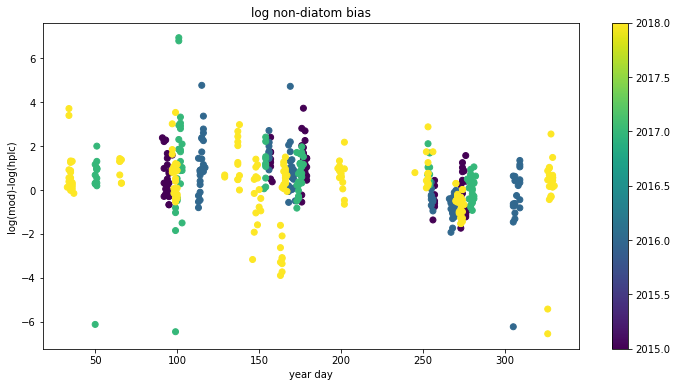

In [18]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
m=ax.scatter(data['yd'],logt(1.8*(data['mod_flagellates']+data['mod_ciliates']))-logt(data['other']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log non-diatom bias')
ax.set_xlabel('year day')
ax.set_ylabel('log(mod)-log(hplc)')

Text(0, 0.5, 'log(mod)-log(hplc)')

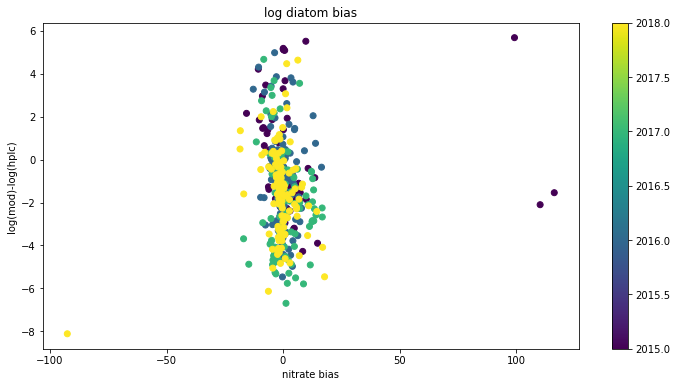

In [19]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
m=ax.scatter(data['mod_nitrate']-data['Nitrate_plus_Nitrite [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('nitrate bias')
ax.set_ylabel('log(mod)-log(hplc)')
#ax.set_xlim(-30,25)

Text(0, 0.5, 'log(mod)-log(hplc)')

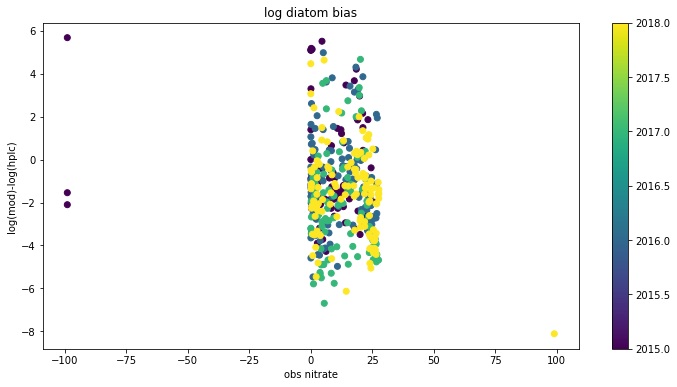

In [20]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
m=ax.scatter(data['Nitrate_plus_Nitrite [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('obs nitrate')
ax.set_ylabel('log(mod)-log(hplc)')
#ax.set_xlim(-1,30)

Text(0, 0.5, 'log(mod)-log(hplc)')

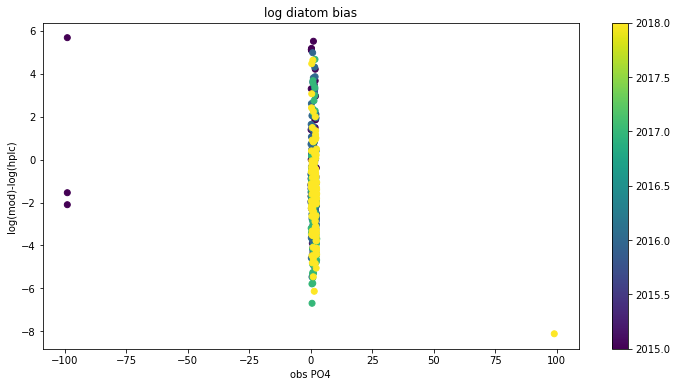

In [21]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
m=ax.scatter(data['Phosphate [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('obs PO4')
ax.set_ylabel('log(mod)-log(hplc)')
#ax.set_xlim(-.1,3)

Text(0, 0.5, 'log(mod)-log(hplc)')

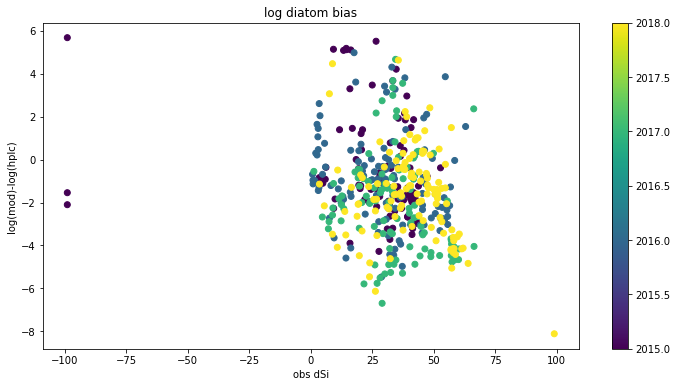

In [22]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
m=ax.scatter(data['Silicate [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('obs dSi')
ax.set_ylabel('log(mod)-log(hplc)')
#ax.set_xlim(-1,70)